In [66]:
#doing things with data
import pandas as pd
import itertools
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

#import r2
from sklearn.metrics import r2_score

import env
import acquire as a
import wrangle as w
import explore as e
import prepare as p
import evaluate as eva

import warnings
warnings.filterwarnings("ignore")

# Acquire
- Performed initial exploratory analysis to ensure required colums were brought in from SQL
- Wrote necessary function to pull data from SQL using embedded ENV/Acquire.py files (repeatable)
- There is a CSV now with the requisite rows, for quicker future access

In [2]:
# get data
df = a.get_zillow()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms
0,429719.0,1476.0,6037.0,0.0,2.0
1,79904.0,1012.0,6037.0,0.0,1.0
2,590000.0,1242.0,6037.0,0.0,2.0
3,355000.0,864.0,6037.0,0.0,1.0
4,2200000.0,1550.0,6037.0,0.0,2.0
...,...,...,...,...,...
52436,544061.0,1419.0,6037.0,0.0,2.0
52437,778732.0,2223.0,6059.0,7.0,2.0
52438,104256.0,2342.0,6059.0,8.0,3.0
52439,314467.0,1393.0,6037.0,0.0,2.0


# Prepare
- Checked for nulls
    - Drop nulls, there are only 220 null values which is .4% of the data. 
    - Dropping them will not have a major impact on the result of the study.
- Encode values for machine learning
- Handle outliers
    - Tax_Value less than 2 million
    - Sqft less than 7250 
    - Bedrooms less than 8
    - Bathrooms less than 5
- Create dummy variable for County location
- Create Wrangle file
- Create Train, Validate, and Test (60%, 20%, 20% : respectively)
- Create scaled data set (to use in modeling phase)

In [8]:
#Check for nulls/missing values
df.isnull().sum()

Tax_Value    0
Sqft         0
County       0
Bedrooms     0
Bathrooms    0
LA           0
Orange       0
Ventura      0
dtype: int64

In [9]:
# Drop nulls, there are only 220 null values which is .4% of the data. 
# Dropping them will not have a major impact on the result of the study.
df = df.dropna()
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura
0,429719.0,1476.0,LA,0.0,2.0,1,0,0
1,79904.0,1012.0,LA,0.0,1.0,1,0,0
2,590000.0,1242.0,LA,0.0,2.0,1,0,0
3,355000.0,864.0,LA,0.0,1.0,1,0,0
4,2200000.0,1550.0,LA,0.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...
52436,544061.0,1419.0,LA,0.0,2.0,1,0,0
52437,778732.0,2223.0,Orange,7.0,2.0,0,1,0
52438,104256.0,2342.0,Orange,8.0,3.0,0,1,0
52439,314467.0,1393.0,LA,0.0,2.0,1,0,0


In [10]:
#Change County code to actual county
df['County'] = df['County'].replace([6037.0, 6059.0, 6111.0],['LA','Orange','Ventura']).astype(str)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura
0,429719.0,1476.0,LA,0.0,2.0,1,0,0
1,79904.0,1012.0,LA,0.0,1.0,1,0,0
2,590000.0,1242.0,LA,0.0,2.0,1,0,0
3,355000.0,864.0,LA,0.0,1.0,1,0,0
4,2200000.0,1550.0,LA,0.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...
52436,544061.0,1419.0,LA,0.0,2.0,1,0,0
52437,778732.0,2223.0,Orange,7.0,2.0,0,1,0
52438,104256.0,2342.0,Orange,8.0,3.0,0,1,0
52439,314467.0,1393.0,LA,0.0,2.0,1,0,0


In [11]:
#Encode values for machine learning
dummy_df = pd.get_dummies(df['County'], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura,LA,Orange,Ventura
0,429719.0,1476.0,LA,0.0,2.0,1,0,0,1,0,0
1,79904.0,1012.0,LA,0.0,1.0,1,0,0,1,0,0
2,590000.0,1242.0,LA,0.0,2.0,1,0,0,1,0,0
3,355000.0,864.0,LA,0.0,1.0,1,0,0,1,0,0
4,2200000.0,1550.0,LA,0.0,2.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
52436,544061.0,1419.0,LA,0.0,2.0,1,0,0,1,0,0
52437,778732.0,2223.0,Orange,7.0,2.0,0,1,0,0,1,0
52438,104256.0,2342.0,Orange,8.0,3.0,0,1,0,0,1,0
52439,314467.0,1393.0,LA,0.0,2.0,1,0,0,1,0,0


- Target = Tax_Value (moved to far left column)

# Handle outliers

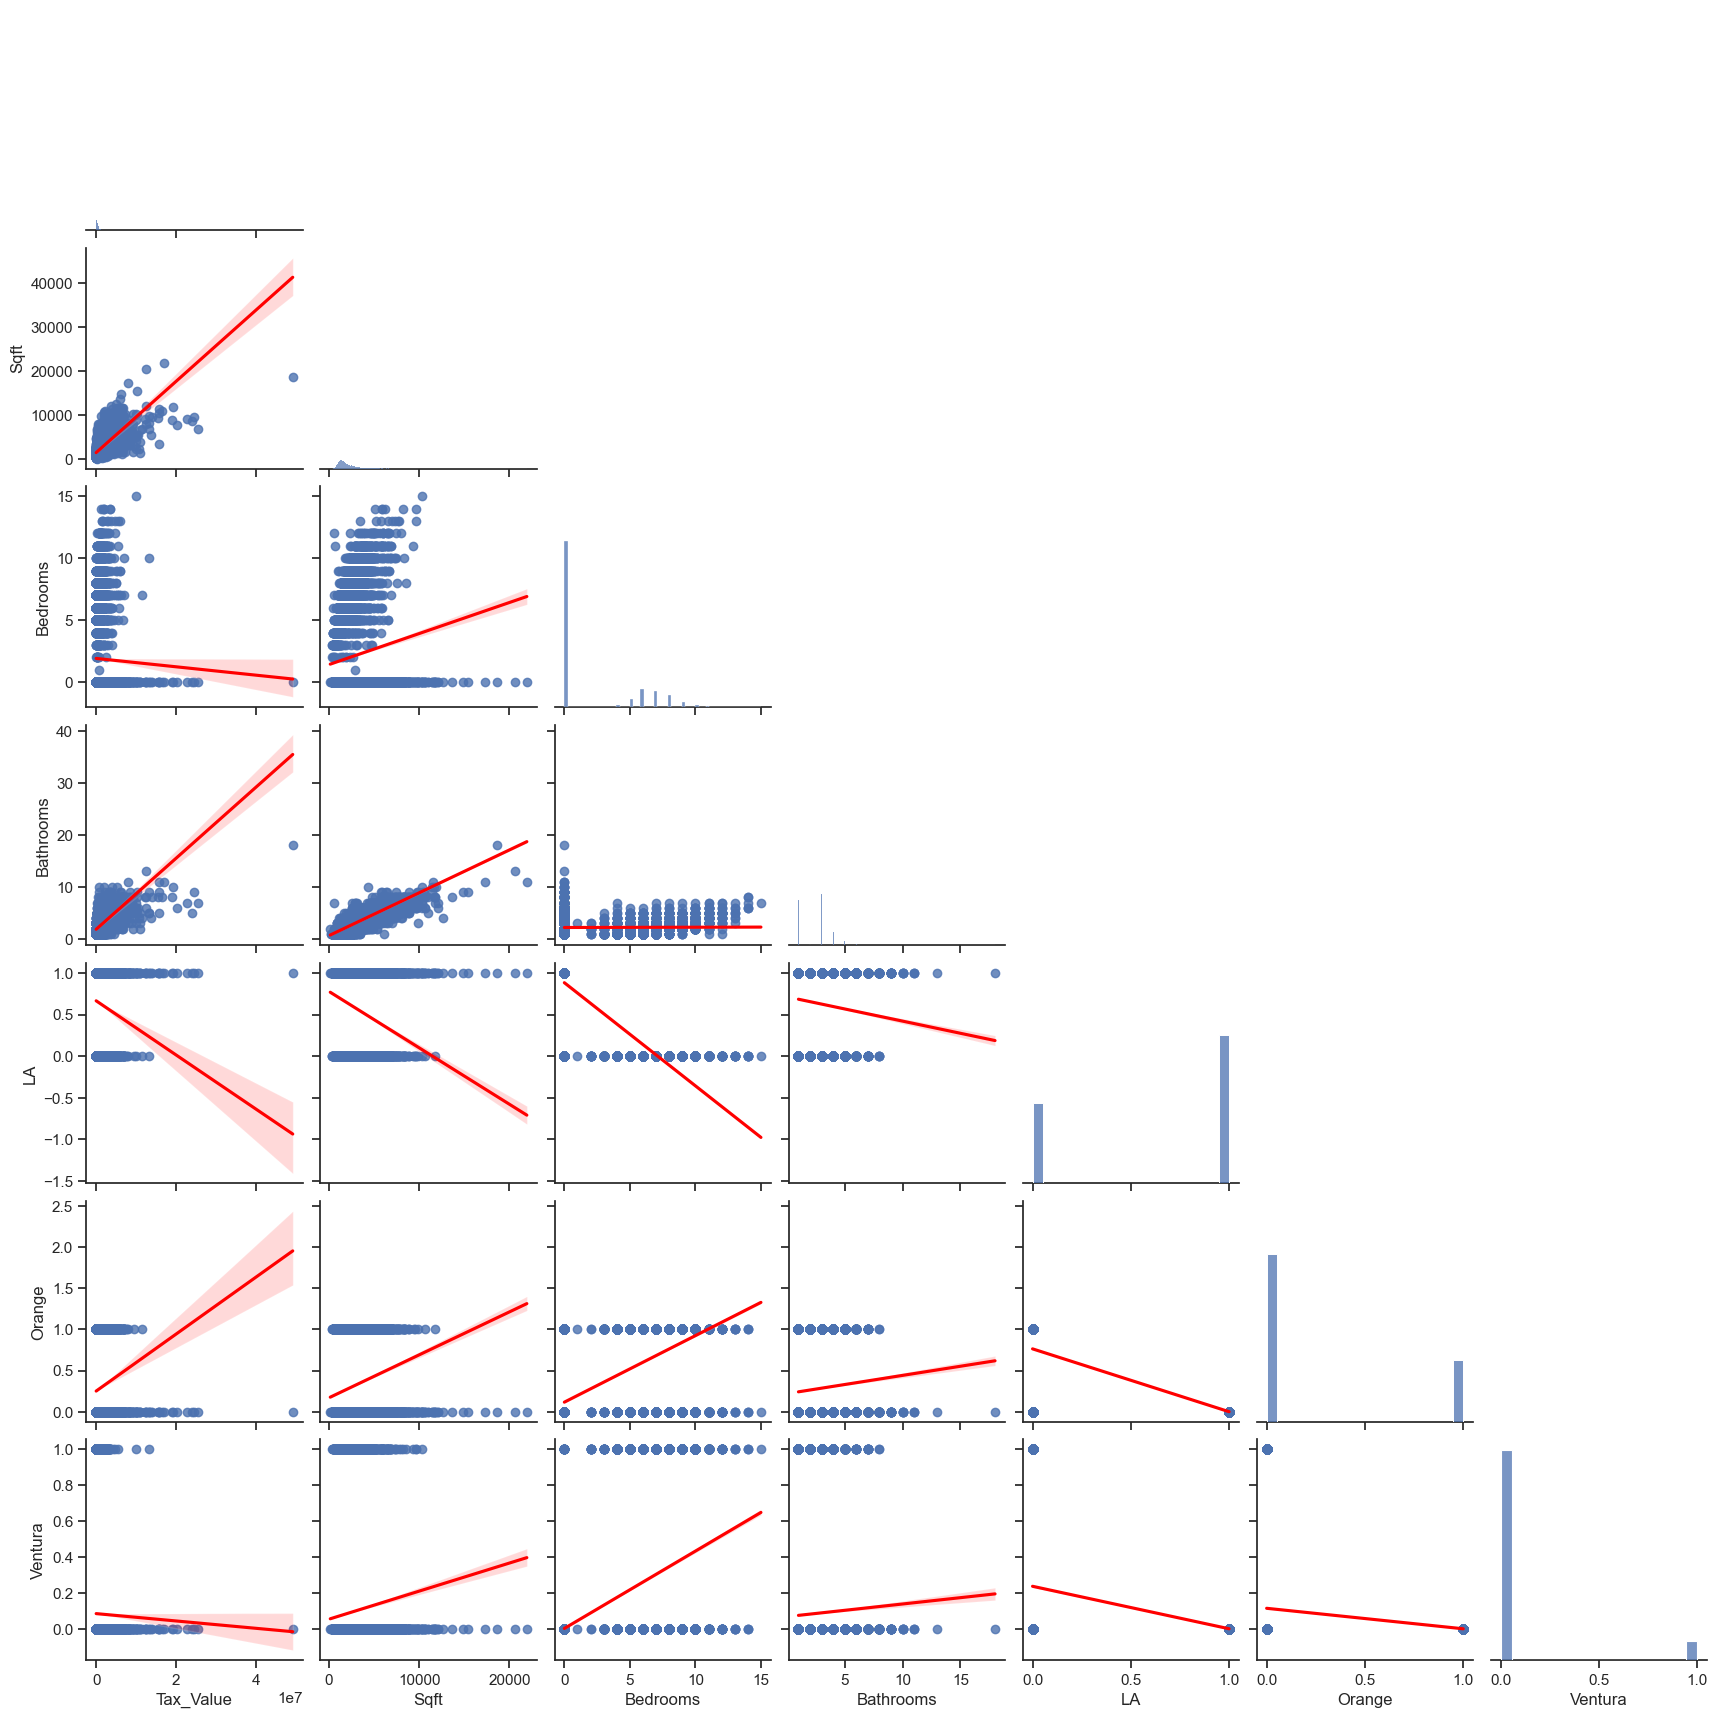

In [7]:
e.plot_variable_pairs(df)

#### Outliers in Tax_Value

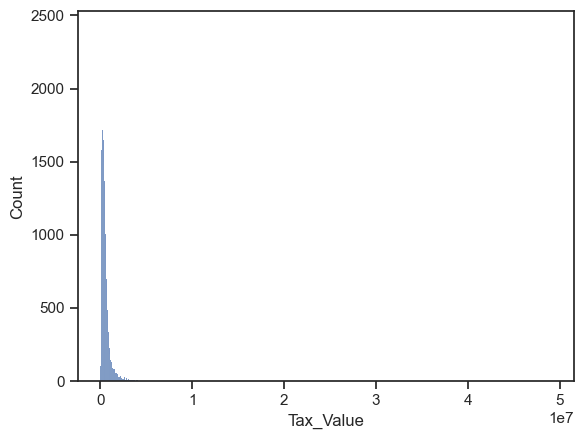

In [12]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Tax_Value)
plt.show()

In [13]:
# Tax_Value less than 2 million
df = df[df.Tax_Value <= 2000000]

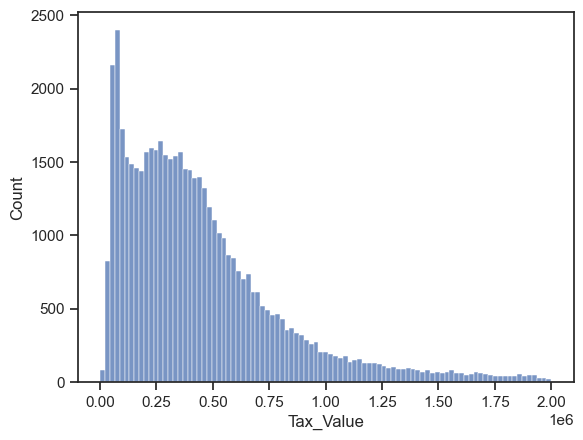

In [14]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Tax_Value)
plt.show()

#### Outliers in Sqft

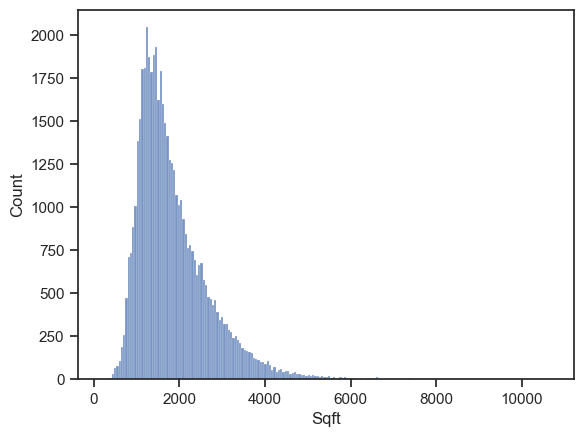

In [15]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Sqft)
plt.show()

In [16]:
# Sqft less than 7250 
df = df[df.Sqft <= 6000]

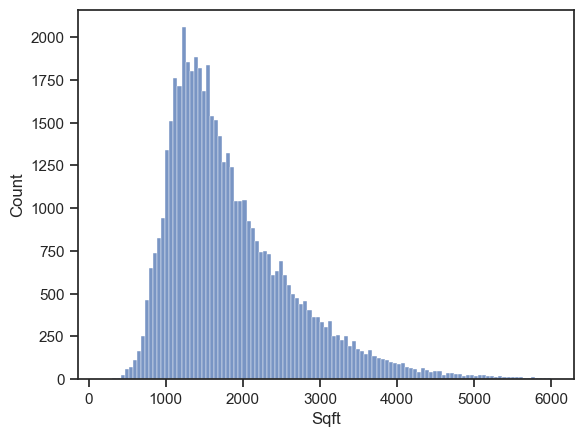

In [17]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Sqft)
plt.show()

#### Outliers in Bedrooms

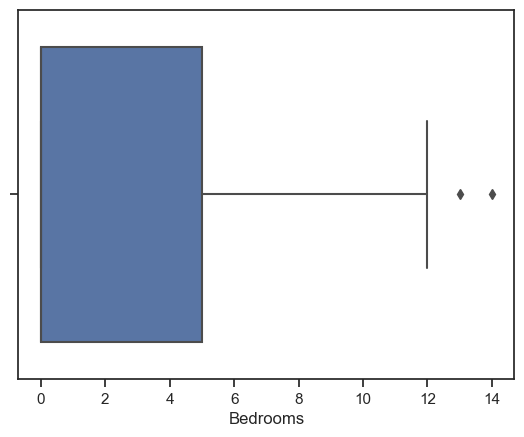

In [18]:
#Bedrooms before outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

In [19]:
# Bathrooms less than 8
df = df[df.Bedrooms <= 8]

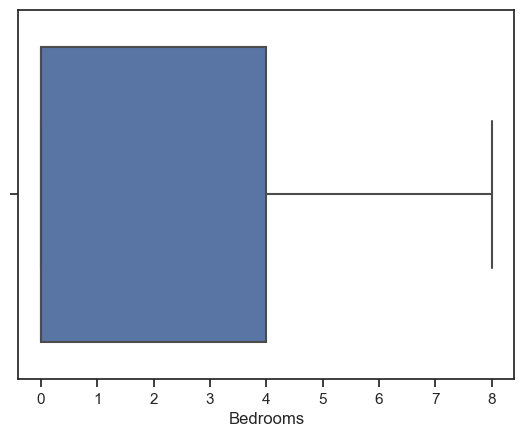

In [20]:
#Bedrooms after outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

#### Outliers in Bathrooms

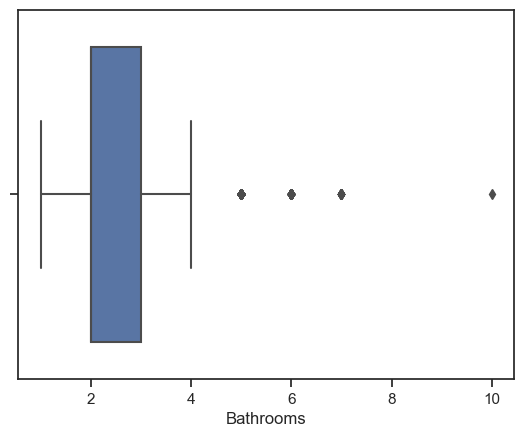

In [21]:
#Bathroom before outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

In [22]:
df.Bathrooms.describe()

count    49264.000000
mean         2.147410
std          0.871286
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Bathrooms, dtype: float64

In [23]:
df.Bathrooms.value_counts()

2.0     25315
3.0     10497
1.0     10370
4.0      2289
5.0       640
6.0       131
7.0        21
10.0        1
Name: Bathrooms, dtype: int64

In [24]:
# Bathrooms less than 5
df = df[df.Bathrooms <= 5]

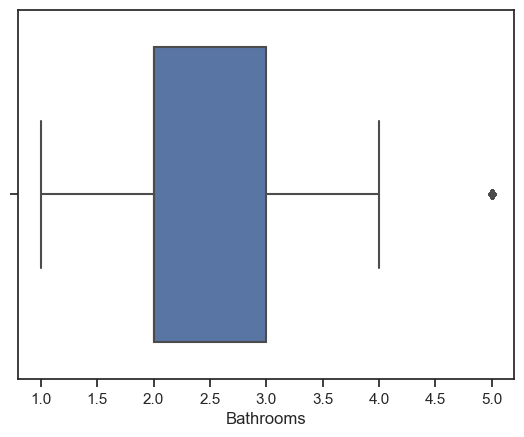

In [25]:
#Bathroom after outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

In [26]:
# After removal of outliers, there have been 3,330 houses removed. That is 7% of the data. 
df.shape

(49111, 11)

# Create Wrangle.py and test

In [28]:
df = w.wrangle_zillow()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura
0,429719.0,1476.0,LA,0.0,2.0,1,0,0
1,79904.0,1012.0,LA,0.0,1.0,1,0,0
2,590000.0,1242.0,LA,0.0,2.0,1,0,0
3,355000.0,864.0,LA,0.0,1.0,1,0,0
5,185716.0,1149.0,LA,0.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...
52436,544061.0,1419.0,LA,0.0,2.0,1,0,0
52437,778732.0,2223.0,Orange,7.0,2.0,0,1,0
52438,104256.0,2342.0,Orange,8.0,3.0,0,1,0
52439,314467.0,1393.0,LA,0.0,2.0,1,0,0


## create train(60%), validate(20%) and test(20%) data set

In [29]:
## create train(60%), validate(20%) and test(20%) data set
train, validate, test = p.split_data(df)
train

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura
46711,44435.0,1101.0,Ventura,5.0,2.0,0,0,1
44708,514070.0,2224.0,LA,0.0,2.0,1,0,0
12896,832188.0,2687.0,Orange,0.0,2.0,0,1,0
39077,693415.0,2000.0,Orange,7.0,2.0,0,1,0
29769,156017.0,976.0,LA,0.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...
11097,255096.0,1252.0,Ventura,6.0,2.0,0,0,1
27013,44847.0,1006.0,LA,0.0,1.0,1,0,0
33608,580000.0,1200.0,LA,0.0,1.0,1,0,0
6484,554526.0,2150.0,Ventura,8.0,3.0,0,0,1


## Create scaled data set for modeling

In [116]:
# Create scaled data for modeling using MinMax scaler
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = p.scaled_df(train, validate, test)
X_train_scaled

,Sqft,Bedrooms,Bathrooms,LA,Orange,Ventura
46711,0.163395,0.625,0.25,0.0,0.0,1.0
44708,0.356749,0.000,0.25,1.0,0.0,0.0
12896,0.436467,0.000,0.25,0.0,1.0,0.0
39077,0.318182,0.875,0.25,0.0,1.0,0.0
29769,0.141873,0.000,0.25,1.0,0.0,0.0
...,...,...,...,...,...,...
11097,0.189394,0.750,0.25,0.0,0.0,1.0
27013,0.147039,0.000,0.00,1.0,0.0,0.0
33608,0.180441,0.000,0.00,1.0,0.0,0.0
6484,0.344008,1.000,0.50,0.0,0.0,1.0


# Explore

**Target = Tax_Value***
- Perform EDA on train data set only
    - How does Sqft affect Tax_Value?
    - How does Bedrooms affect Tax_Value?
    - How does Bathrooms affect Tax_Value?
    - Does location affect Tax_Value? Which location is the most expensive? The cheapest?
- Visualize relationships
- Confirm relationships with statistical testing
- Use Kbest and/or RFE (recursive feature elimination)

In [34]:
# look at train
train.head()

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,LA,Orange,Ventura
46711,44435.0,1101.0,Ventura,5.0,2.0,0,0,1
44708,514070.0,2224.0,LA,0.0,2.0,1,0,0
12896,832188.0,2687.0,Orange,0.0,2.0,0,1,0
39077,693415.0,2000.0,Orange,7.0,2.0,0,1,0
29769,156017.0,976.0,LA,0.0,2.0,1,0,0


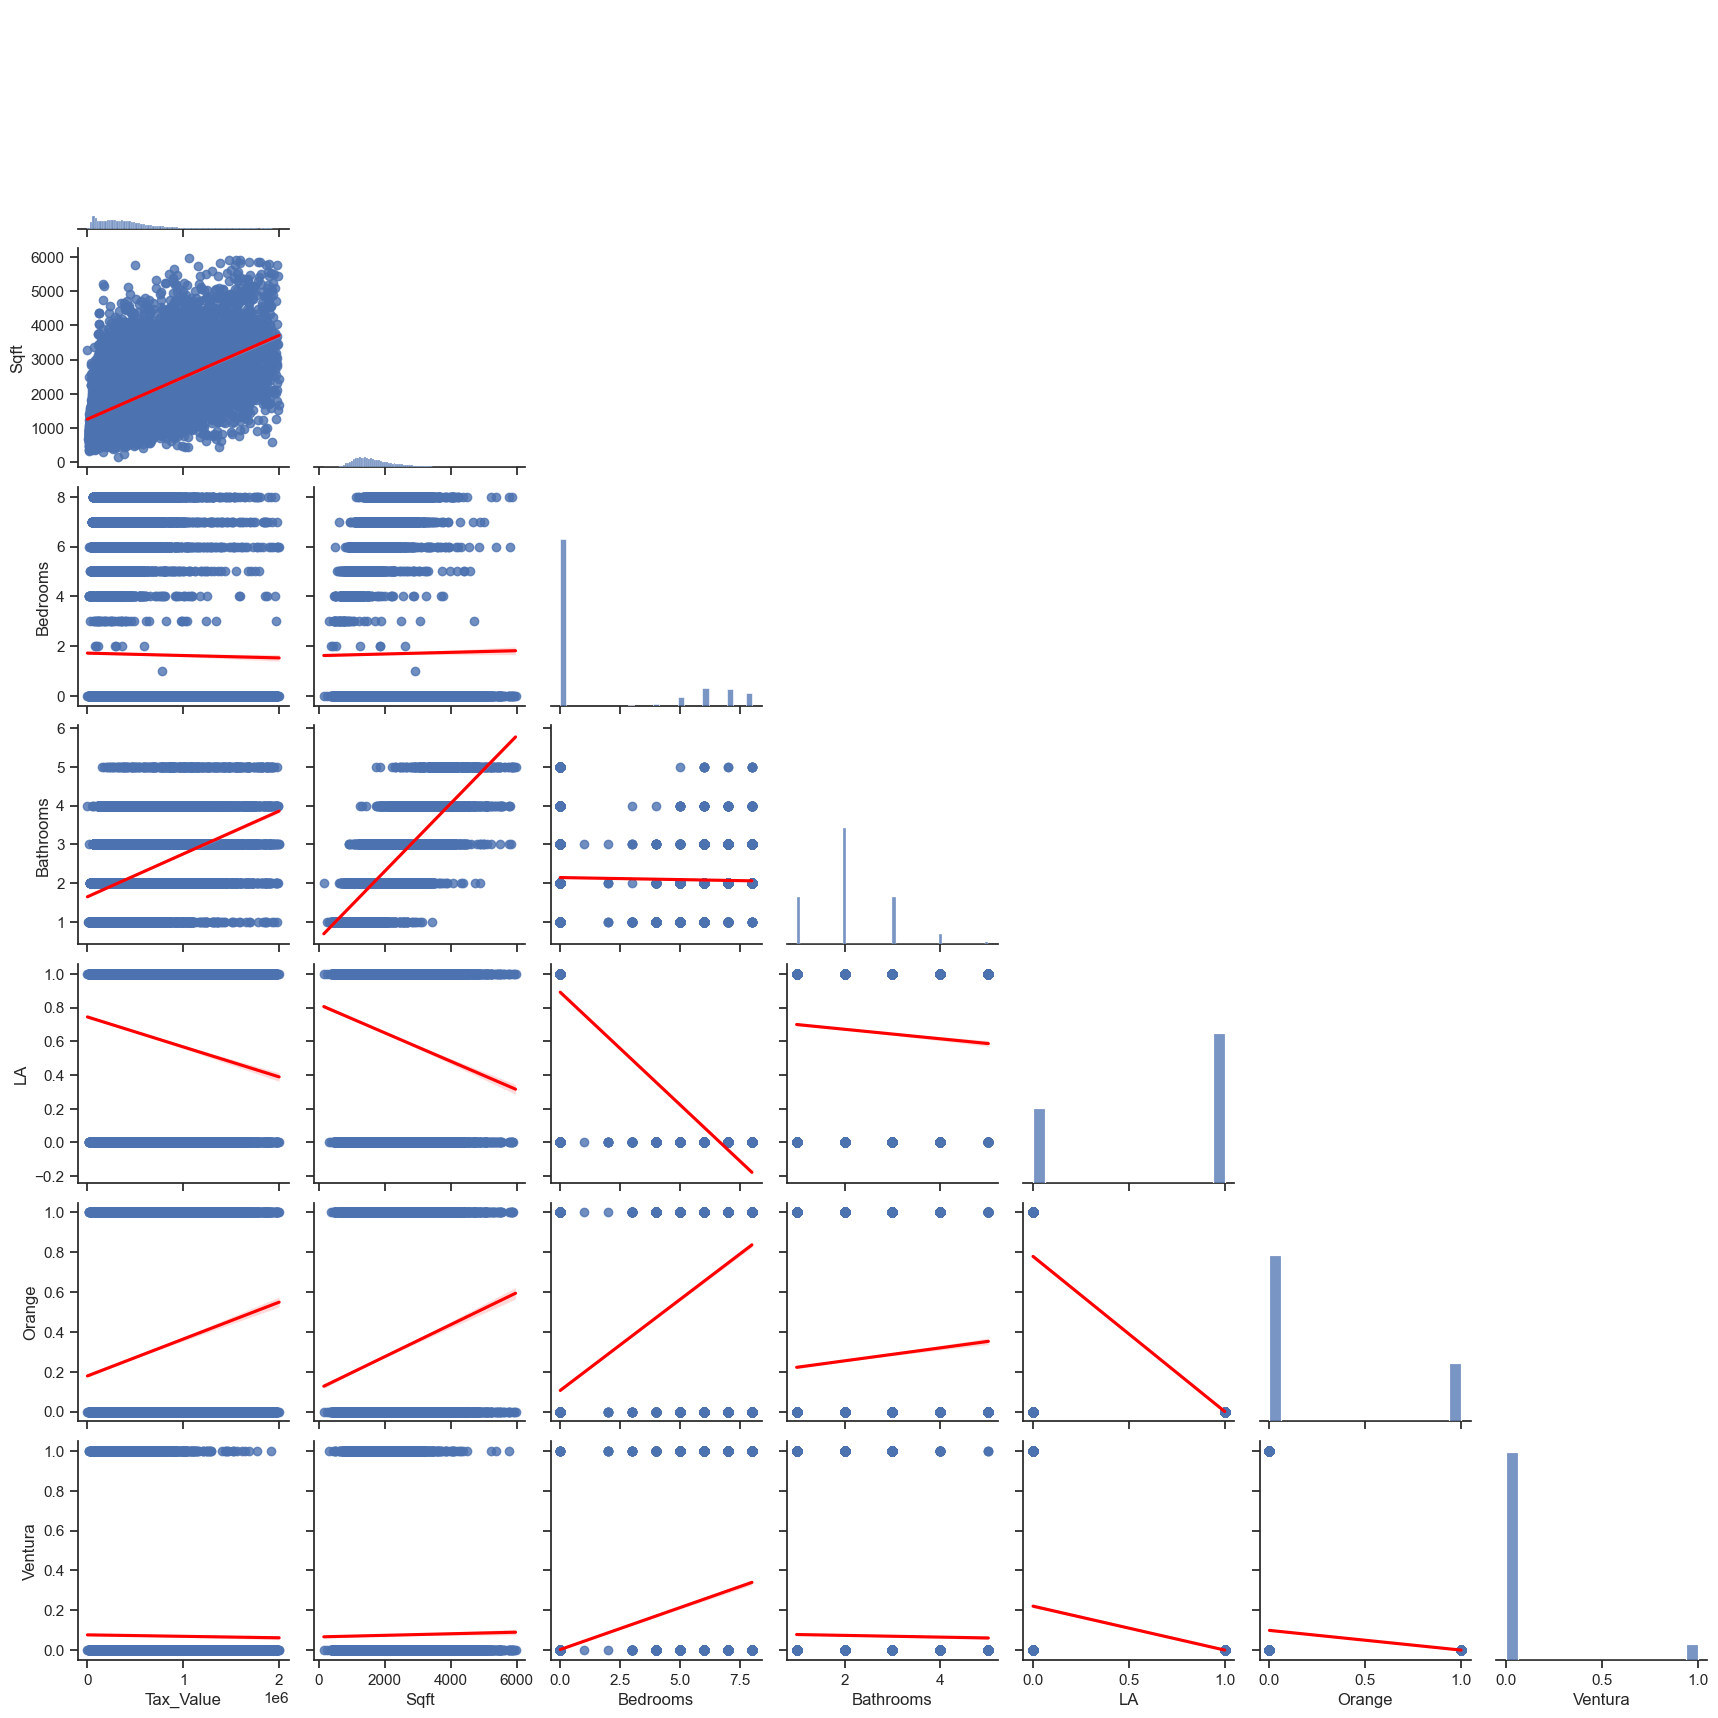

In [44]:
# Visualize pairwise relationships
e.plot_variable_pairs(train)

# Relationship between Sqft and Tax_Value
 $H_{0}$ Sqft does not influence price.
    
 $H_{a}$ Sqft does influence price.

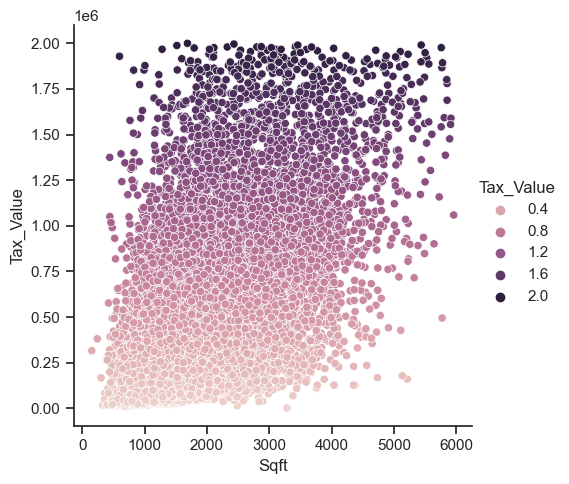

In [43]:
#Visualize Sqft and Tax_Value
sns.relplot(x=train.Sqft, y=train.Tax_Value, hue=train.Tax_Value)
plt.show()

#### Stats test
- Run stats test to confirm Hypothesis


In [52]:
r,p = pearsonr(train.Sqft, train.Tax_Value)
r,p

(0.552104844113956, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Sqft does affect Tax_Value

# Relationship between Tax_Value (continuous) and County (categorical)
 $H_{0}$ Location does not affect price.
    
 $H_{a}$ Location does affect price.

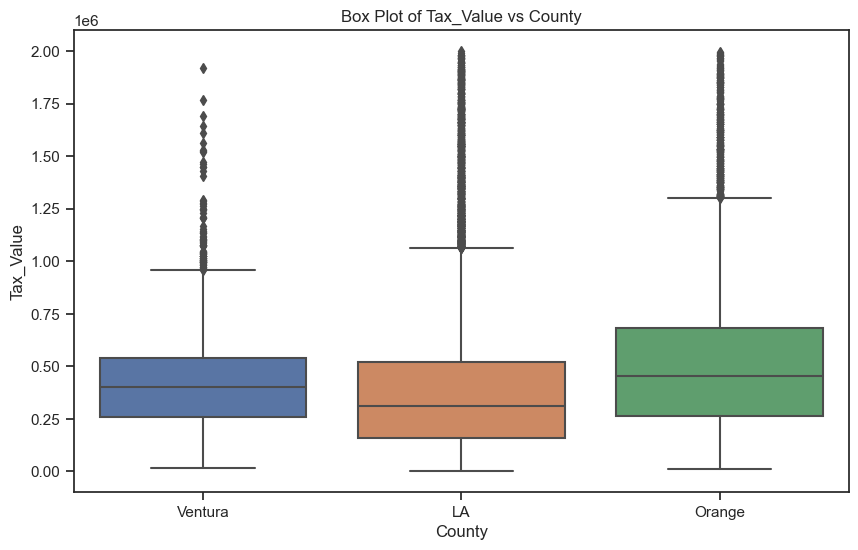

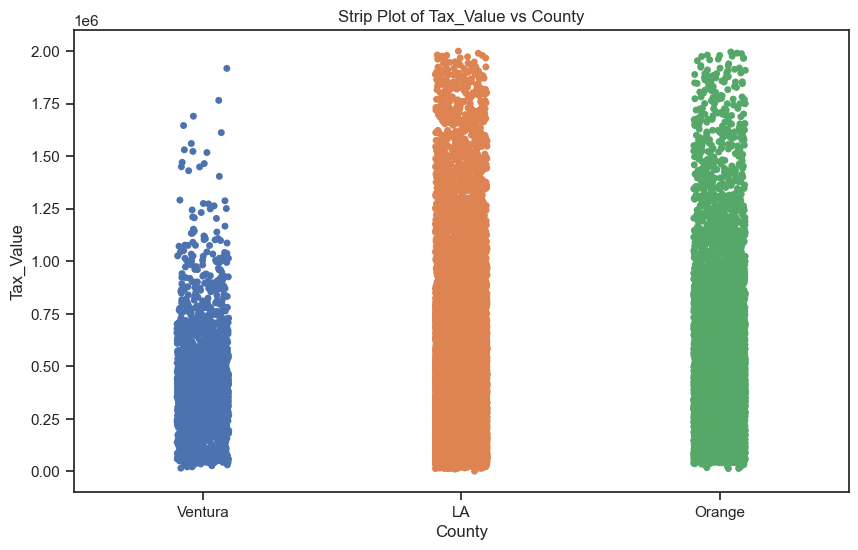

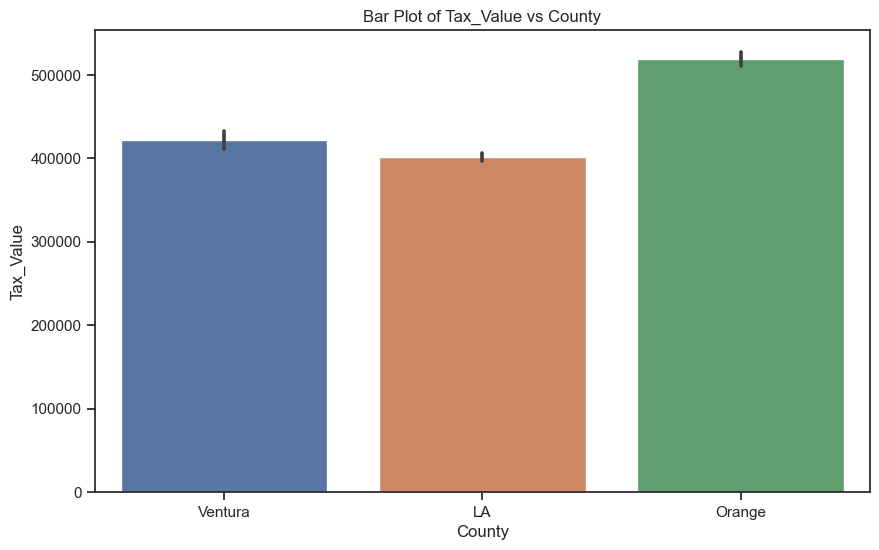

In [49]:
# Visualize
e.plot_categorical_and_continuous_vars(train, 'County', 'Tax_Value')

### prepare data for ANOVA stats test

In [51]:
la = train[train.County == 'LA'].Tax_Value
orange = train[train.County == 'Orange'].Tax_Value
ventura = train[train.County == 'Ventura'].Tax_Value
tstat, pval = stats.f_oneway(la, orange, ventura)
tstat, pval

(324.0699822053267, 6.080087948115872e-140)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that County location does affect Tax_Value

### Tax_Value (continuous) and Bedrooms (categorical)
 $H_{0}$ Number of Bedrooms does not affect price.
    
 $H_{a}$ Number of Bedrooms does affect price.

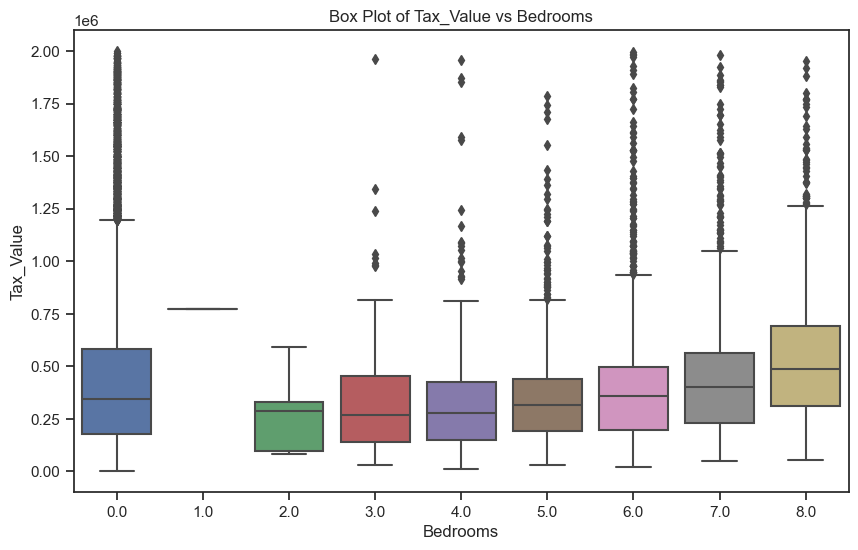

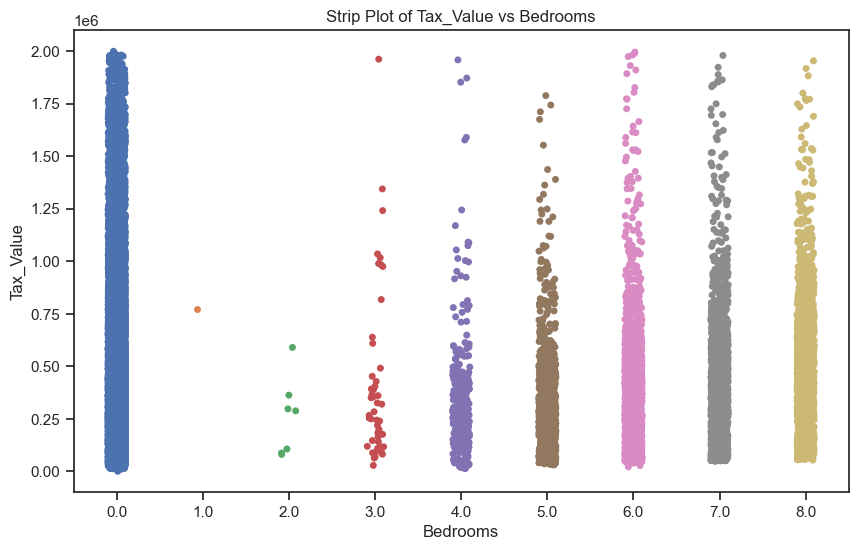

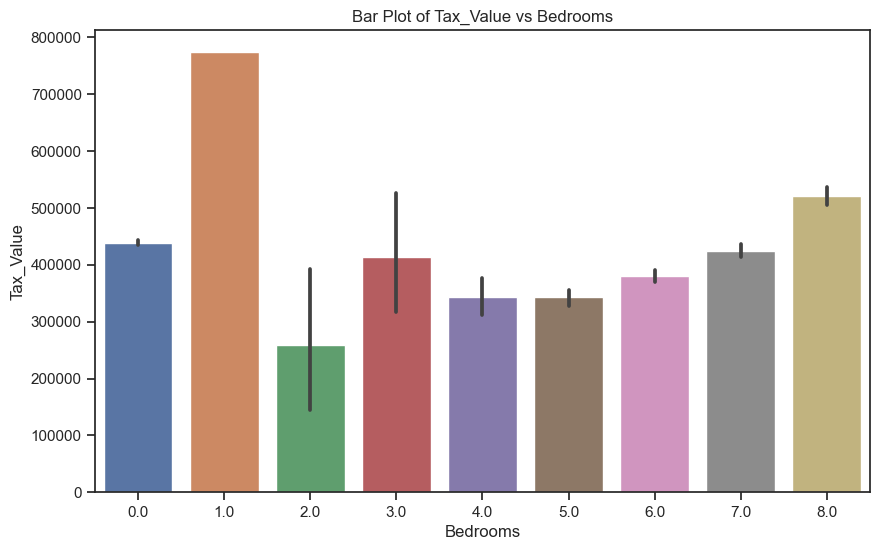

In [53]:
e.plot_categorical_and_continuous_vars(train, 'Bedrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [54]:
tstat, pval = stats.ttest_ind(train.Bedrooms, train.Tax_Value)
tstat, pval

(-215.61595994977446, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Sqft does affect Tax_Value

### Tax_Value (continuous) and Bathrooms (categorical)
 $H_{0}$ Number of Bathrooms does not affect price.
    
 $H_{a}$ Number of Bathrooms does affect price.

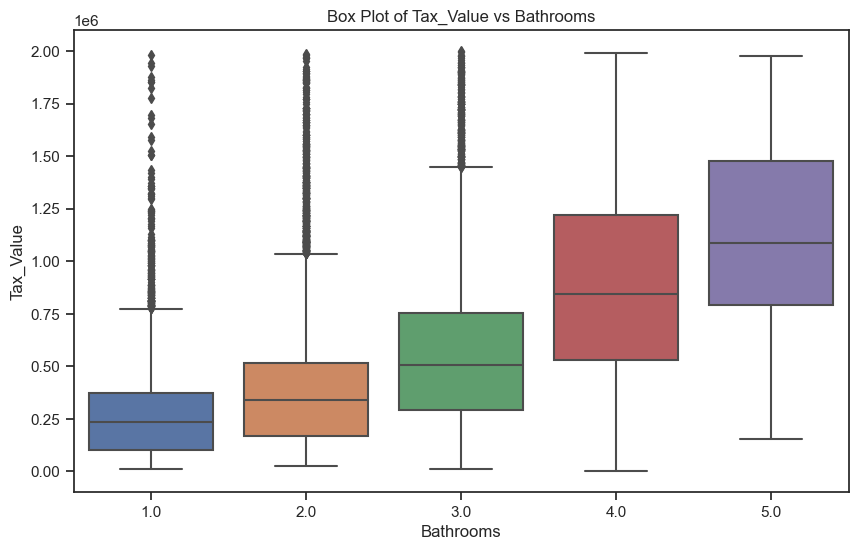

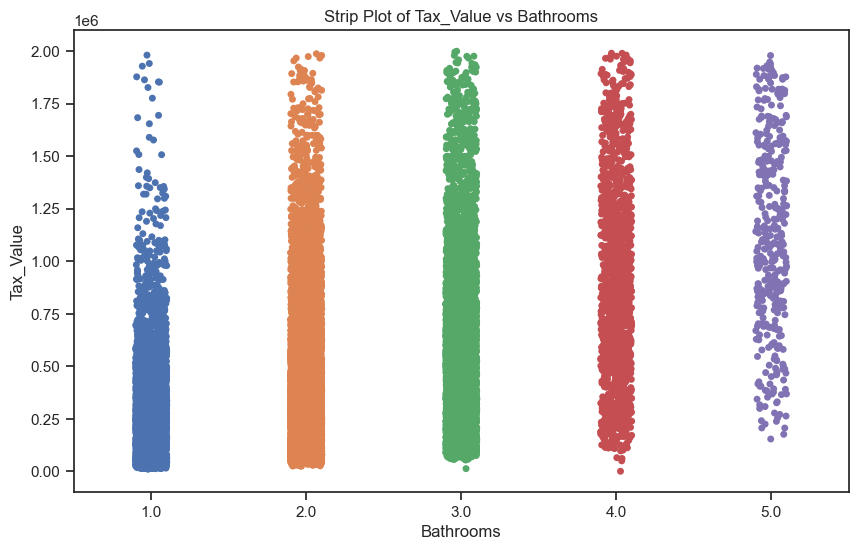

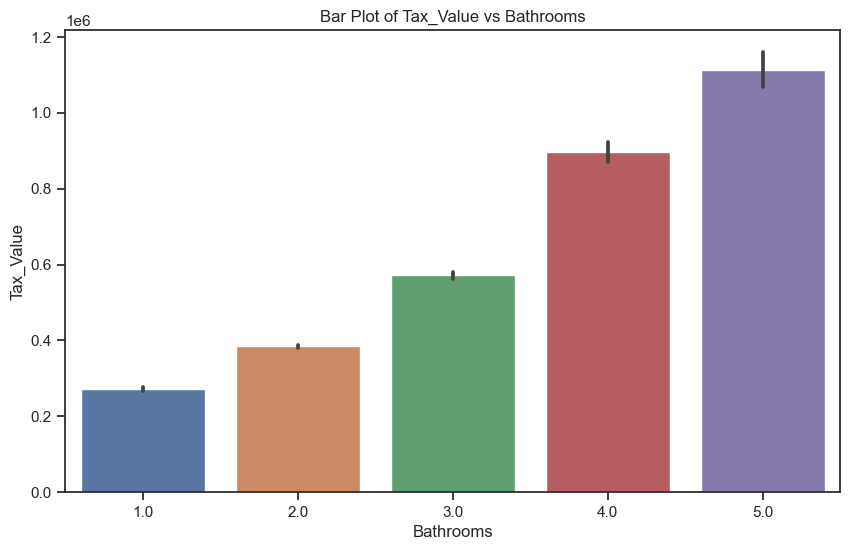

In [55]:
e.plot_categorical_and_continuous_vars(train, 'Bathrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [56]:
tstat, pval = stats.ttest_ind(train.Bathrooms, train.Tax_Value)
tstat, pval

(-215.615733224941, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Sqft does affect Tax_Value

### What independent variables are correlated with the dependent variable, home value?
- Sqft are highly correlated with taxvalue.
- Bathroom and sqft are moderately correlated.
- Interesting enough, Bedrooms has a slight negative correlation.
- Orange county seems to have the highest positive correlation amongst the three locations.

In [57]:
train.corr(method='pearson')

,Tax_Value,Sqft,Bedrooms,Bathrooms,LA,Orange,Ventura
Tax_Value,1.000000,0.552105,-0.011444,0.454582,-0.130379,0.145968,-0.009701
Sqft,0.552105,1.000000,0.008741,0.796882,-0.137114,0.140528,0.011608
Bedrooms,-0.011444,0.008741,1.000000,-0.036212,-0.820534,0.603717,0.468125
Bathrooms,0.454582,0.796882,-0.036212,1.000000,-0.050331,0.062399,-0.013911
LA,-0.130379,-0.137114,-0.820534,-0.050331,1.000000,-0.837953,-0.398795
Orange,0.145968,0.140528,0.603717,0.062399,-0.837953,1.000000,-0.166296
Ventura,-0.009701,0.011608,0.468125,-0.013911,-0.398795,-0.166296,1.000000


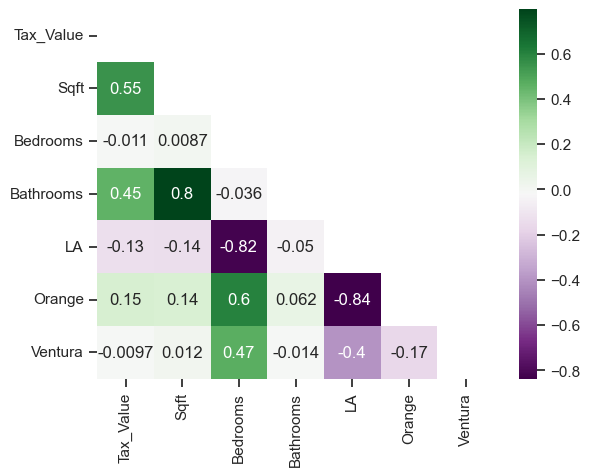

In [58]:
# Correlation heat map
sns.heatmap(train.corr(method='pearson'), cmap='PRGn', annot=True,
           mask=np.triu(train.corr(method='pearson')))
plt.show()

# Exploration Takeaways

- All features are statistically significant to Tax_Value. I will start using them all in my models.
- Sqft and Bathrooms are the highest correlated independent variables to the target.

# Modeling

### Set and explore the target (Tax_Value)



In [60]:
# set baseline
baseline = round(y_train.mean(),2)
baseline

433274.67

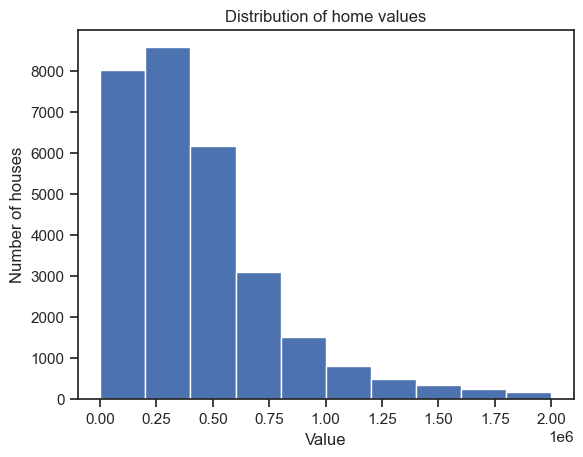

In [61]:
#visualize baseline
plt.hist(y_train)
plt.xlabel("Value")
plt.ylabel("Number of houses")
plt.title('Distribution of home values')
plt.show()

In [62]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([433274.67, 433274.67, 433274.67, ..., 433274.67, 433274.67,
       433274.67])

In [63]:
# Evaluate the baseline rmse and r2
rmse, r2 = eva.metrics_reg(y_train, baseline_array)
rmse, r2

(344932.360405534, 1.1102230246251565e-16)

In [64]:
# add results to a dataframe for comparison
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,344932.360406,1.110223e-16


# OLS - Ordinary Least Squares
# Multiple Regression
- also using Recursive Feature Eliminations

In [73]:
#### make it
OLS = LinearRegression()
#use Recursive Feature Eliminations
rfe = RFE(OLS, n_features_to_select=6)
#fit it
rfe.fit(X_train_scaled, y_train)
#use it on train
X_train_rfe = rfe.transform(X_train_scaled)
#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)

In [74]:
#see what the top features are regardless of location
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['Sqft' 'Bedrooms' 'Bathrooms' 'LA' 'Orange' 'Ventura']


In [75]:
#get array of rfe rankings and choose top minus location
rfe.ranking_

array([1, 1, 1, 1, 1, 1])

In [ ]:
# see whats in the rfe
X_train_rfe

In [76]:
#put results into a dataframe
pd.DataFrame(
{'rfe_ranking':rfe.ranking_},
index=X_train_scaled.columns)

,rfe_ranking
Sqft,1
Bedrooms,1
Bathrooms,1
LA,1
Orange,1
Ventura,1


In [ ]:
# make a mask for the rfe
rfe.get_support()

In [77]:
#apply the mask to the transformed data
X_train_RFEtransformed = pd.DataFrame(
    rfe.transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[rfe.support_])
X_train_RFEtransformed.head()

,Sqft,Bedrooms,Bathrooms,LA,Orange,Ventura
46711,0.163395,0.625,0.25,0.0,0.0,1.0
44708,0.356749,0.000,0.25,1.0,0.0,0.0
12896,0.436467,0.000,0.25,0.0,1.0,0.0
39077,0.318182,0.875,0.25,0.0,1.0,0.0
29769,0.141873,0.000,0.25,1.0,0.0,0.0


### Build model


In [78]:
# build model for the top features
#fit the thing
OLS.fit(X_train_rfe, y_train)
#use the thing (make predictions)
pred_OLS = OLS.predict(X_train_rfe)
pred_val_OLS = OLS.predict(X_val_rfe)

### Evaluate


In [79]:
# Evaluate Train
eva.metrics_reg(y_train, pred_OLS)

(284190.1071349223, 0.3211871877520195)

In [80]:
# Evaluate Validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_OLS)
rmse, r2

(286081.60981355637, 0.31884468957852097)

In [81]:
#add to my metrics df
metrics_df.loc[1] = ['OLS', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,344932.360406,1.110223e-16
1,OLS,286081.609814,3.188447e-01


In [ ]:
### Examine the model

In [82]:
OLS.intercept_

141337.00306616072

In [83]:
OLS.coef_

array([1259452.38401005, -182050.98399127,   86802.93226234,
       -102985.04910784,   61161.37650233,   41823.67260551])

In [86]:
print(f'final_grade = {OLS.intercept_:.3} + {OLS.coef_[0]:.2}*Sqft \
 {OLS.coef_[1]:.2}*Bedrooms + {OLS.coef_[2]:.2}*Bathrooms {OLS.coef_[3]:.2}*LA +\
 {OLS.coef_[4]:.2}*Orange +{OLS.coef_[5]:.2}*Ventura')

final_grade = 1.41e+05 + 1.3e+06*Sqft  -1.8e+05*Bedrooms + 8.7e+04*Bathrooms -1e+05*LA + 6.1e+04*Orange +4.2e+04*Ventura


In [87]:
print(f'For every 1 point increase in Sqft, we predict a {OLS.coef_[0]:.2f} point increase in Tax_Value')
print(f'For every 1 point increase in Bedrooms, we predict a {OLS.coef_[1]:.2f} point decrease in Tax_Value')
print(f'For every 1 point increase in Bathrooms, we predict a {OLS.coef_[2]:.2f} point increase in Tax_Value')
print(f'For every 1 point increase in LA, we predict a {OLS.coef_[3]:.2f} point decrease in Tax_Value')
print(f'For every 1 point increase in Orange, we predict a {OLS.coef_[4]:.2f} point increase in Tax_Value')
print(f'For every 1 point increase in Ventura, we predict a {OLS.coef_[5]:.2f} point increase in Tax_Value')

For every 1 point increase in Sqft, we predict a 1259452.38 point increase in Tax_Value
For every 1 point increase in Bedrooms, we predict a -182050.98 point decrease in Tax_Value
For every 1 point increase in Bathrooms, we predict a 86802.93 point increase in Tax_Value
For every 1 point increase in LA, we predict a -102985.05 point decrease in Tax_Value
For every 1 point increase in Orange, we predict a 61161.38 point increase in Tax_Value
For every 1 point increase in Ventura, we predict a 41823.67 point increase in Tax_Value


# LassoLars

In [89]:
#make it
lars = LassoLars(normalize=False, alpha=1)
#fit it
lars.fit(X_train_scaled, y_train)
#use it
pred_lars = lars.predict(X_train_scaled)
pred_val_lars = lars.predict(X_validate_scaled)

#### evaluate

In [90]:
#train
eva.metrics_reg(y_train, pred_lars)

(284190.1073250717, 0.3211871868436428)

In [91]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_lars)
rmse, r2

(286081.4917584354, 0.31884525175276224)

In [92]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,344932.360406,1.110223e-16
1,OLS,286081.609814,3.188447e-01
3,lars,286081.491758,3.188453e-01


# Polynomial Regression

In [93]:
# make the polynomial features to get a new set of features
# degree of 1 will be the same as our original data
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_val_degree2 = pf.transform(X_validate_scaled)

X_test_degree2 = pf.transform(X_test_scaled)

#### fit on a linear regression model

In [94]:
#make it
pr = LinearRegression()
#fit it
pr.fit(X_train_degree2, y_train)
#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_val_degree2)

#### evaluate

In [95]:
#train
eva.metrics_reg(y_train, pred_pr)

(282370.1464283555, 0.3298536177748569)

In [96]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_pr)
rmse, r2

(284611.59728767775, 0.32582685290346236)

In [97]:
#add to my metrics df
metrics_df.loc[4] = ['pr', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,344932.360406,1.110223e-16
1,OLS,286081.609814,3.188447e-01
3,lars,286081.491758,3.188453e-01
4,pr,284611.597288,3.258269e-01


# Generalized Linear Model (GLM)

In [98]:
#make it
glm = TweedieRegressor(power=1, alpha=0)
#fit it
glm.fit(X_train_scaled, y_train)
#use it
pred_glm = glm.predict(X_train_scaled)
pred_val_glm = glm.predict(X_validate_scaled)

#### evaluate

In [99]:
#train
eva.metrics_reg(y_train, pred_glm)

(285621.9568825533, 0.314329760540358)

In [100]:
rmse, r2 = eva.metrics_reg(y_validate, pred_val_glm)
rmse, r2

(289961.9742965643, 0.30024121223782985)

In [101]:
#add to my metrics df
metrics_df.loc[5] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,344932.360406,1.110223e-16
1,OLS,286081.609814,3.188447e-01
3,lars,286081.491758,3.188453e-01
4,pr,284611.597288,3.258269e-01
5,glm,289961.974297,3.002412e-01


### Evaluate on Best Model

In [102]:
#use it
pred_test = pr.predict(X_test_degree2)

In [103]:
eva.metrics_reg(y_test, pred_test)

(284683.3287522411, 0.3460353106175097)

In [104]:
# Prepare for visualization

In [106]:
plot_df = pd.DataFrame({'pred_OLS': pred_OLS,
                        'pred_lars': pred_lars,
                        'pred_pr': pred_pr,
                        'pred_glm': pred_glm,
                        'index': X_train_scaled.index})
plot_df

,pred_OLS,pred_lars,pred_pr,pred_glm,index
0,296868.165028,296869.694580,272440.0,325610.662540,46711
1,509361.457628,509356.799070,470728.0,447393.633555,44708
2,773908.443465,773875.827351,753816.0,682059.945878,12896
3,465639.351099,465644.503129,461976.0,442241.035008,39077
4,238735.325527,238744.890699,253304.0,286909.122259,29769
...,...,...,...,...,...
29461,306855.819231,306859.904695,290104.0,334454.103949,11097
29462,223540.028329,223545.498167,256560.0,265973.498265,27013
29463,265608.513608,265611.772384,289936.0,284991.224407,33608
29464,477773.186608,477779.344574,497944.0,475663.987692,6484


In [107]:
ploty_df = pd.DataFrame({'actual': y_train,
                        'index': y_train.index})
ploty_df

,actual,index
46711,44435.0,46711
44708,514070.0,44708
12896,832188.0,12896
39077,693415.0,39077
29769,156017.0,29769
...,...,...
11097,255096.0,11097
27013,44847.0,27013
33608,580000.0,33608
6484,554526.0,6484


In [108]:
merged_df = pd.merge(plot_df, ploty_df, on='index')
merged_df.set_index('index', inplace=True)
merged_df

,pred_OLS,pred_lars,pred_pr,pred_glm,actual
index,,,,,
46711,296868.165028,296869.694580,272440.0,325610.662540,44435.0
44708,509361.457628,509356.799070,470728.0,447393.633555,514070.0
12896,773908.443465,773875.827351,753816.0,682059.945878,832188.0
39077,465639.351099,465644.503129,461976.0,442241.035008,693415.0
29769,238735.325527,238744.890699,253304.0,286909.122259,156017.0
...,...,...,...,...,...
11097,306855.819231,306859.904695,290104.0,334454.103949,255096.0
27013,223540.028329,223545.498167,256560.0,265973.498265,44847.0
33608,265608.513608,265611.772384,289936.0,284991.224407,580000.0


In [109]:
plot_this = merged_df
plot_this

,pred_OLS,pred_lars,pred_pr,pred_glm,actual
index,,,,,
46711,296868.165028,296869.694580,272440.0,325610.662540,44435.0
44708,509361.457628,509356.799070,470728.0,447393.633555,514070.0
12896,773908.443465,773875.827351,753816.0,682059.945878,832188.0
39077,465639.351099,465644.503129,461976.0,442241.035008,693415.0
29769,238735.325527,238744.890699,253304.0,286909.122259,156017.0
...,...,...,...,...,...
11097,306855.819231,306859.904695,290104.0,334454.103949,255096.0
27013,223540.028329,223545.498167,256560.0,265973.498265,44847.0
33608,265608.513608,265611.772384,289936.0,284991.224407,580000.0


In [110]:
# plot actuals vs predicted

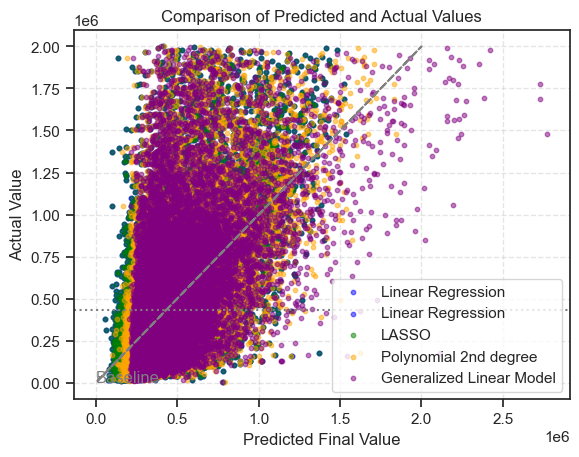

In [112]:
plt.scatter(plot_this.pred_OLS, plot_this.actual, label='Linear Regression', alpha=0.5, color='blue', s=10)
plt.scatter(plot_this.pred_lars, plot_this.actual, label='LASSO', alpha=0.5, color='green', s=10)
plt.scatter(plot_this.pred_pr, plot_this.actual, label='Polynomial 2nd degree', alpha=0.5, color='orange', s=10)
plt.scatter(plot_this.pred_glm, plot_this.actual, label='Generalized Linear Model', alpha=0.5, color='purple', s=10)

plt.plot(plot_this.actual, plot_this.actual, label='_nolegend_', color='grey', linestyle='--')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81), color='grey')

plt.title("Comparison of Predicted and Actual Values")
plt.ylabel("Actual Value")
plt.xlabel("Predicted Final Value")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5) 

plt.show()

#### plotting the residuals

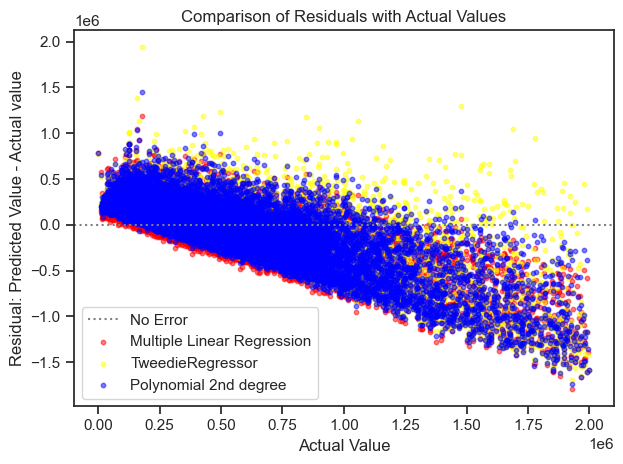

In [114]:
plt.axhline(0, ls=':', color='grey', label="No Error")

plt.scatter(plot_this.actual, plot_this.pred_OLS - plot_this.actual, alpha=0.5, color="red", s=10, label="Multiple Linear Regression")
plt.scatter(plot_this.actual, plot_this.pred_glm - plot_this.actual, alpha=0.5, color="yellow", s=10, label="TweedieRegressor")
plt.scatter(plot_this.actual, plot_this.pred_pr - plot_this.actual, alpha=0.5, color="blue", s=10, label="Polynomial 2nd degree")

plt.legend()
plt.title("Comparison of Residuals with Actual Values")
plt.xlabel("Actual Value")
plt.ylabel("Residual: Predicted Value - Actual value")

plt.tight_layout()

plt.show()

#### histogram of actual and predicted values

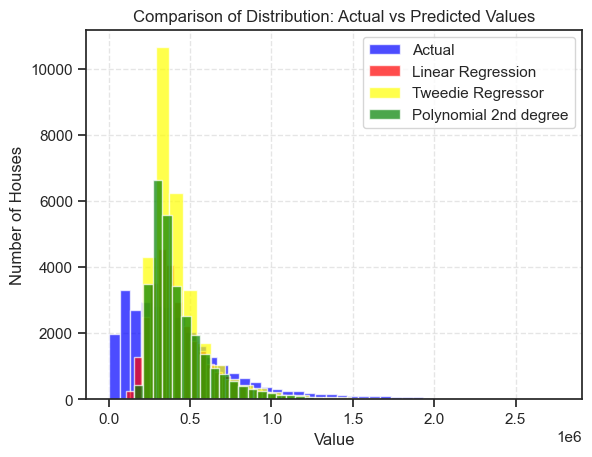

In [115]:
plt.hist(plot_this.actual, bins=30, color='blue', alpha=0.7, label="Actual")
plt.hist(plot_this.pred_OLS, bins=30, color='red', alpha=0.7, label="Linear Regression")
plt.hist(plot_this.pred_glm, bins=30, color='yellow', alpha=0.7, label="Tweedie Regressor")
plt.hist(plot_this.pred_pr, bins=30, color='green', alpha=0.7, label="Polynomial 2nd degree")

plt.xlabel("Value")
plt.ylabel("Number of Houses")
plt.title("Comparison of Distribution: Actual vs Predicted Values")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines

plt.show()


# Modeling Takeaways
- best performing model was Polynomial Regression
- the R^2 value is .33 and has the lowest RMSE of the 4 models that were ran
- with more time I would like to introduce more features into the model such as pools, AC, lot size and combining features such as full and half baths. Lastly, I would look at regression prediction on location independent values